<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Robust-Regression" data-toc-modified-id="Robust-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Robust Regression</a></span></li><li><span><a href="#Step-2---Define-the-descriptive-statistical-model-\begin{align*}
y_i-&amp;\sim-Student(\nu,-\mu,-\sigma)-
\\-\nu--&amp;\sim-Gamma(2,-1)
\\-\mu_i-&amp;=-\beta_0-+-\beta_1x-+-\beta_2x
\\-\beta_0-&amp;\sim-normal(0,-1)
\\-\beta_1-&amp;\sim-normal(0,-1)
\\-\beta_2-&amp;\sim-normal(0,-1)-
\\-\sigma-&amp;\sim-Exponential(1)
\end{align*}" data-toc-modified-id="Step-2---Define-the-descriptive-statistical-model-\begin{align*}
y_i-&amp;\sim-Student(\nu,-\mu,-\sigma)-
\\-\nu--&amp;\sim-Gamma(2,-1)
\\-\mu_i-&amp;=-\beta_0-+-\beta_1x-+-\beta_2x
\\-\beta_0-&amp;\sim-normal(0,-1)
\\-\beta_1-&amp;\sim-normal(0,-1)
\\-\beta_2-&amp;\sim-normal(0,-1)-
\\-\sigma-&amp;\sim-Exponential(1)
\end{align*}-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Step 2 - Define the descriptive statistical model <script type="math/tex; mode=display" id="MathJax-Element-15">\begin{align*}
y_i &\sim Student(\nu, \mu, \sigma) 
\\ \nu  &\sim Gamma(2, 1)
\\ \mu_i &= \beta_0 + \beta_1x + \beta_2x
\\ \beta_0 &\sim normal(0, 1)
\\ \beta_1 &\sim normal(0, 1)
\\ \beta_2 &\sim normal(0, 1) 
\\ \sigma &\sim Exponential(1)
\end{align*}</script></a></span></li><li><span><a href="#Step-4---Use-Bayes-rule." data-toc-modified-id="Step-4---Use-Bayes-rule.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step 4 - Use Bayes rule.</a></span></li><li><span><a href="#Stan-model-of-a-Bayesian-robust-regression" data-toc-modified-id="Stan-model-of-a-Bayesian-robust-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stan model of a Bayesian robust regression</a></span></li><li><span><a href="#Step-5---Posterior-predictive-checks" data-toc-modified-id="Step-5---Posterior-predictive-checks-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step 5 - Posterior predictive checks</a></span><ul class="toc-item"><li><span><a href="#posterior-p-values" data-toc-modified-id="posterior-p-values-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>posterior p-values</a></span></li></ul></li><li><span><a href="#Reporting-the-results-of-the-Bayesian-robust-regression" data-toc-modified-id="Reporting-the-results-of-the-Bayesian-robust-regression-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Reporting the results of the Bayesian robust regression</a></span><ul class="toc-item"><li><span><a href="#Write-up" data-toc-modified-id="Write-up-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span><font size="3">Write up</font></a></span></li></ul></li></ul></div>

In [5]:
# Import relveant libraries/packages.
import pystan as ps
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('ggplot')

In [1]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Robust Regression

The data example below is from https://www.sheffield.ac.uk/mash/statistics/datasets. The code below is for conducting Robust regression which differs based on the use of student-t distrtibution as the likelihood function to model the data and accomadate outliers.

In [11]:
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/Data/Crime.csv"
df = pd.read_csv(url)
df.head()

,CrimeRate,Youth,Southern,Education,ExpenditureYear0,LabourForce,Males,MoreMales,StateSize,YouthUnemployment,...,ExpenditureYear10,LabourForce10,Males10,MoreMales10,StateSize10,YouthUnemploy10,MatureUnemploy10,HighYouthUnemploy10,Wage10,BelowWage10
0,45.5,135,0,12.4,69,540,965,0,6,80,...,71,564,974,0,6,82,20,1,632,142
1,52.3,140,0,10.9,55,535,1045,1,6,135,...,54,540,1039,1,7,138,39,1,521,210
2,56.6,157,1,11.2,47,512,962,0,22,97,...,44,529,959,0,24,98,33,0,359,256
3,60.3,139,1,11.9,46,480,968,0,19,135,...,41,497,983,0,20,131,50,0,510,235
4,64.2,126,0,12.2,106,599,989,0,40,78,...,97,602,989,0,42,79,24,1,660,162


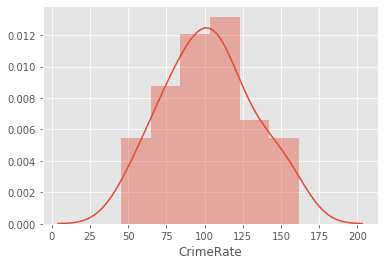

In [13]:
sns.distplot(df["CrimeRate"]);

# Step 2 - Define the descriptive statistical model \begin{align*}
y_i &\sim Student(\nu, \mu, \sigma) 
\\ \nu  &\sim Gamma(2, 1)
\\ \mu_i &= \beta_0 + \beta_1x + \beta_2x
\\ \beta_0 &\sim normal(0, 1)
\\ \beta_1 &\sim normal(0, 1)
\\ \beta_2 &\sim normal(0, 1) 
\\ \sigma &\sim Exponential(1)
\end{align*} 

<font size = "3">The formulation for presenting statistical models here follows that used by McElreath (2020) for its intuitive nature. In plain english the model specifies that the dependent variable $y_i$ (diffence scores of gaze proportion  is distributed normally in terms of the likelihood with the prior on $\mu$ being Normally distributed with a $\mu$ of 0  and $\sigma$ of 0.2. In addito the prior on the $\sigma$ parameter of likelihood being exponetial distributed with a $\lambda$ of 0.1. </font>

# Step 4 - Use Bayes rule.

The software of choice to conduct Bayesian inference on the data here is Stan and the model is specified below.

# Stan model of a Bayesian robust regression

In [32]:
Robust_Regression = """
data {
  int<lower=0> N;   // Sample size
  int<lower=0> K;   // Number of predictor variables
  matrix[N, K] x;   // Predictor variable (IV) matrix
  vector[N] y;      // Vector of Dependent variable (DV) values
}

transformed data{
 vector[N] y_std = (y - mean(y)) / sd(y);
 matrix[N, K] x_std;
 for (i in 2:K){
 x_std[,i] = (x[,i] - mean(x[,i])) / sd(x[,i]);
 
  }
}

parameters{
  real nu;  // degrees of freedom       
  vector[K] beta;       // Coefficients for interpectp and predictors
  real<lower=0> sigma;  // Standard deviation
}

model {

//priors
nu ~ gamma(2, .1);
beta ~ normal(0, 1);
sigma ~ normal(0, 1);

//Likelihood
  y ~ student_t(nu, x * beta, sigma);  // likelihood
}

generated quantities{
//Transform data back to the original scale


// Generate posterior p-value variable 
int<lower = 0, upper = 1> mean_pv;
int<lower = 0, upper = 1> sd_pv;

real ypred[N] = student_t_rng(nu, x*beta, sigma);
}
"""

In [33]:
# StanModel function can be called and be passed the model string specified above to compile into C++ code.
sm  = ps.StanModel(model_code = Robust_Regression)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44a54ca7c95a0fc2f2f53e2fd9632139 NOW.


In [ ]:
x = pt.dmatrix(" ~ Inherence_Bias", data = df)
x = np.asarray(x)

data = {'N': len(filtered),
        'y': filtered["Ought_Score"].values,
        'x': x,
        'K': x.shape[1]
       }

# Step 5 - Posterior predictive checks

## posterior p-values

# Reporting the results of the Bayesian robust regression

<font size = "3">As Kruscke correctly points out there is not standard formula or presentation method for reuslts in journal article like the APA guide for reporting frequentist analysis. It is likely there never will be, because as McElreath (2020) explains Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2017) argue visualisations maybe even more key so the all the visualtions above would have to be included with any write up. Anyway below the write up as  below genral follows the advice of Kruscke (2015) chapter 25. In any application though it comes down to the problem to be described an the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>
